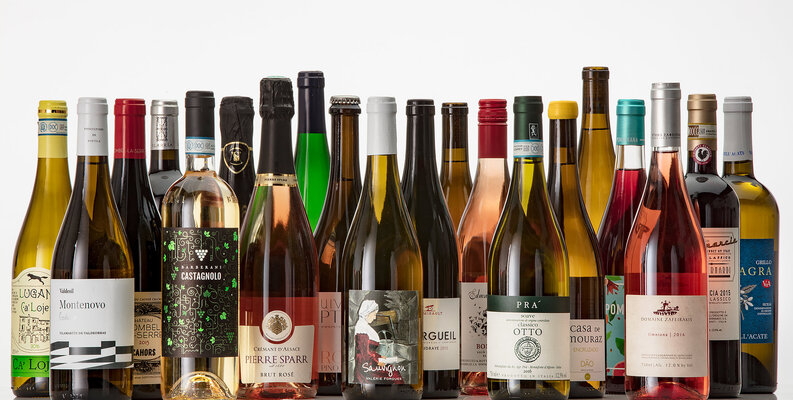

# Import libraries

In [1]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import *

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

!pip install lazypredict
from lazypredict.Supervised import LazyClassifier
from IPython.display import clear_output
clear_output()

# Data review

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv",index_col=0)
test = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv',index_col=0)
submission = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv",index_col=0)

In [3]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,8.00,0.50,0.39,2.20,0.07,30.00,39.00,1.00,3.33,0.77,12.10,6
1,9.30,0.30,0.73,2.30,0.09,30.00,67.00,1.00,3.32,0.67,12.80,6
2,7.10,0.51,0.03,2.10,0.06,3.00,12.00,1.00,3.52,0.73,11.30,7
3,8.10,0.87,0.22,2.60,0.08,11.00,65.00,1.00,3.20,0.53,9.80,5
4,8.50,0.36,0.30,2.30,0.08,10.00,45.00,0.99,3.20,1.36,9.50,6


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 0 to 2055
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2056 non-null   float64
 1   volatile acidity      2056 non-null   float64
 2   citric acid           2056 non-null   float64
 3   residual sugar        2056 non-null   float64
 4   chlorides             2056 non-null   float64
 5   free sulfur dioxide   2056 non-null   float64
 6   total sulfur dioxide  2056 non-null   float64
 7   density               2056 non-null   float64
 8   pH                    2056 non-null   float64
 9   sulphates             2056 non-null   float64
 10  alcohol               2056 non-null   float64
 11  quality               2056 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 208.8 KB


In [5]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
2056,7.20,0.51,0.01,2.00,0.08,31.00,54.00,1.00,3.39,0.59,9.80
2057,7.20,0.76,0.15,2.00,0.10,14.00,35.00,1.00,3.33,0.68,10.00
2058,8.40,0.46,0.40,2.00,0.07,21.00,50.00,1.00,3.08,0.65,9.50
2059,8.00,0.47,0.40,1.80,0.06,14.00,25.00,0.99,3.30,0.65,11.70
2060,6.50,0.34,0.32,2.10,0.04,8.00,94.00,0.99,3.23,0.48,12.80


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 2056 to 3427
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1372 non-null   float64
 1   volatile acidity      1372 non-null   float64
 2   citric acid           1372 non-null   float64
 3   residual sugar        1372 non-null   float64
 4   chlorides             1372 non-null   float64
 5   free sulfur dioxide   1372 non-null   float64
 6   total sulfur dioxide  1372 non-null   float64
 7   density               1372 non-null   float64
 8   pH                    1372 non-null   float64
 9   sulphates             1372 non-null   float64
 10  alcohol               1372 non-null   float64
dtypes: float64(11)
memory usage: 128.6 KB


In [7]:
# describe
train.iloc[:, :-1].describe().T.sort_values(by='mean' , ascending = False).style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000').bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
total sulfur dioxide,2056.00,49.24,32.96,7.00,22.00,44.00,65.00,289.00
free sulfur dioxide,2056.00,16.96,10.01,1.00,8.00,16.00,24.00,68.00
alcohol,2056.00,10.41,1.03,8.70,9.50,10.10,11.00,14.00
fixed acidity,2056.00,8.37,1.71,5.00,7.20,7.95,9.20,15.90
pH,2056.00,3.31,0.14,2.74,3.20,3.31,3.39,3.78
residual sugar,2056.00,2.40,0.86,1.20,1.90,2.20,2.60,14.00
density,2056.00,1.00,0.00,0.99,1.00,1.00,1.00,1.00
sulphates,2056.00,0.64,0.14,0.39,0.55,0.61,0.72,1.95
volatile acidity,2056.00,0.53,0.17,0.18,0.39,0.52,0.64,1.58
citric acid,2056.00,0.27,0.19,0.00,0.09,0.25,0.42,0.76


# Visualization

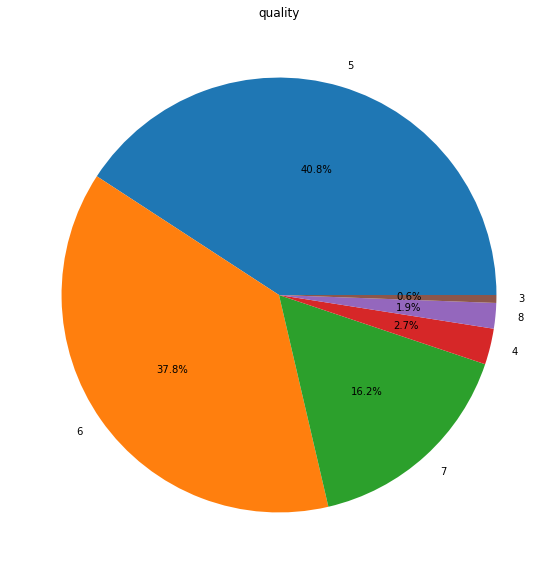

In [8]:
# quality class percentages
plt.figure(figsize=(10,10))
plt.pie(train['quality'].value_counts().values, labels=train['quality'].value_counts().index, autopct=lambda x: '{:.1f}%'.format(x))
plt.title('quality')
plt.show()

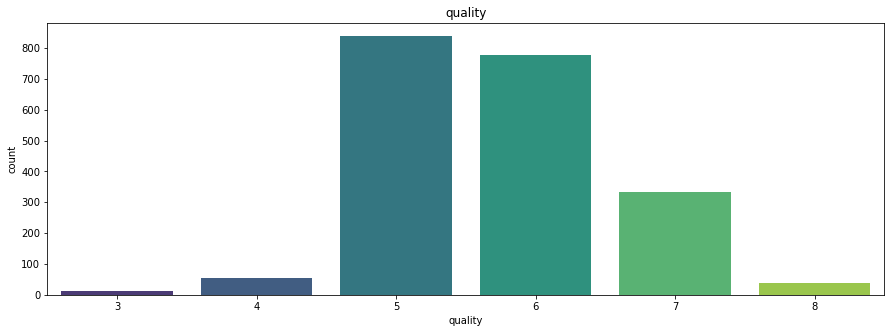

In [9]:
# quality class count
plt.figure(figsize=(15,5))
sns.countplot(palette='viridis', data=train, x='quality')
plt.title('quality')
plt.show()

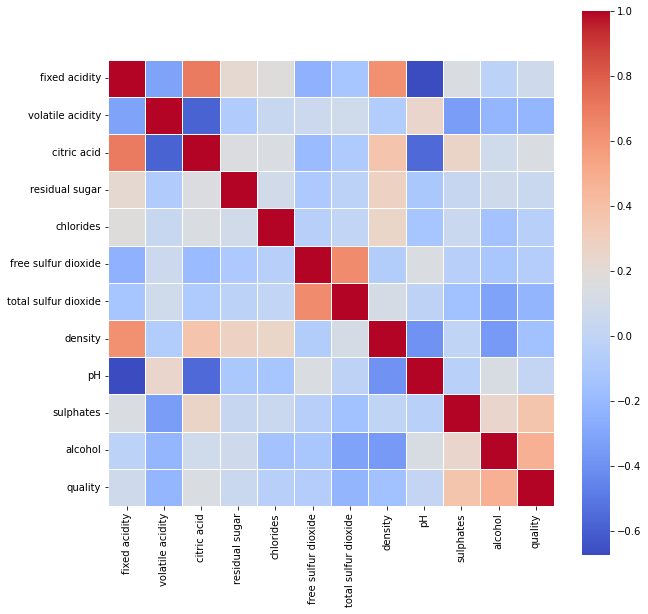

In [10]:
# correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(data=train.corr(), linewidths=1, square=True, cmap='coolwarm')
plt.show()

# Processing

In [11]:
# correlation
train.corrwith(train.quality).abs().sort_values(ascending=False)*100

quality                100.00
alcohol                 48.28
sulphates               36.69
total sulfur dioxide    22.57
volatile acidity        21.93
density                 15.32
citric acid             14.18
fixed acidity            7.39
free sulfur dioxide      6.02
residual sugar           4.82
chlorides                4.66
pH                       1.64
dtype: float64

In [12]:
# drop column with low correlation
test = test.drop('pH',axis=1)
train = train.drop('pH',axis=1)

# Lazypredict

In [13]:
# split
X = train.drop('quality', axis=1)
y = train.quality

X_train , X_test , y_train , y_test = train_test_split(X , y, random_state=7, test_size=0.2)

In [14]:
# LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, random_state=7, classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)
clear_output()

In [15]:
# result
models.sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.59,0.27,None,0.57,0.05
SVC,0.58,0.26,None,0.56,0.23
LogisticRegression,0.58,0.26,None,0.55,0.08
QuadraticDiscriminantAnalysis,0.58,0.29,None,0.56,0.02
LinearSVC,0.58,0.24,None,0.52,0.57
GaussianNB,0.58,0.30,None,0.56,0.01
RidgeClassifierCV,0.58,0.24,None,0.52,0.03
RidgeClassifier,0.58,0.24,None,0.52,0.02
CalibratedClassifierCV,0.57,0.24,None,0.53,2.04


# Train model

In [16]:
# class prior probabilities for lda model
y.value_counts(normalize=True).sort_index()

3   0.01
4   0.03
5   0.41
6   0.38
7   0.16
8   0.02
Name: quality, dtype: float64

In [17]:
# fitting LinearDiscriminantAnalysis model
model = LinearDiscriminantAnalysis(priors=y.value_counts(normalize=True).sort_index())
model.fit(X_train, y_train)

LinearDiscriminantAnalysis(priors=3   0.01
4   0.03
5   0.41
6   0.38
7   0.16
8   0.02
Name: quality, dtype: float64)

In [18]:
# evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         7
           5       0.68      0.78      0.72       183
           6       0.50      0.54      0.52       145
           7       0.45      0.31      0.37        65
           8       0.00      0.00      0.00        10

    accuracy                           0.58       412
   macro avg       0.27      0.27      0.27       412
weighted avg       0.55      0.58      0.56       412



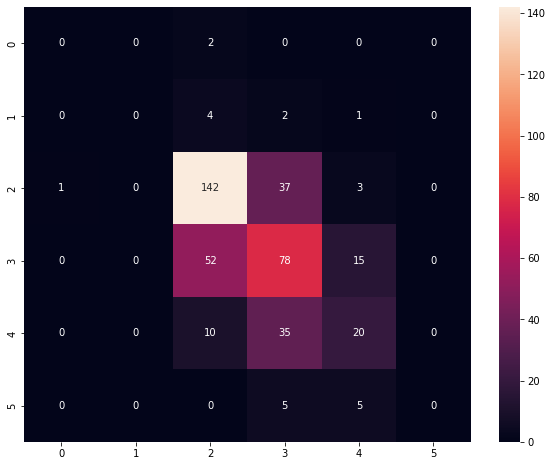

In [19]:
# confusion matrix
plt.figure(figsize=(10,8))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="g")
plt.show()

In [20]:
# Multi-class ROC curve calculation functions
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
        
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
            
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
        
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
        
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
        
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
        
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
            
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
        
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
        
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

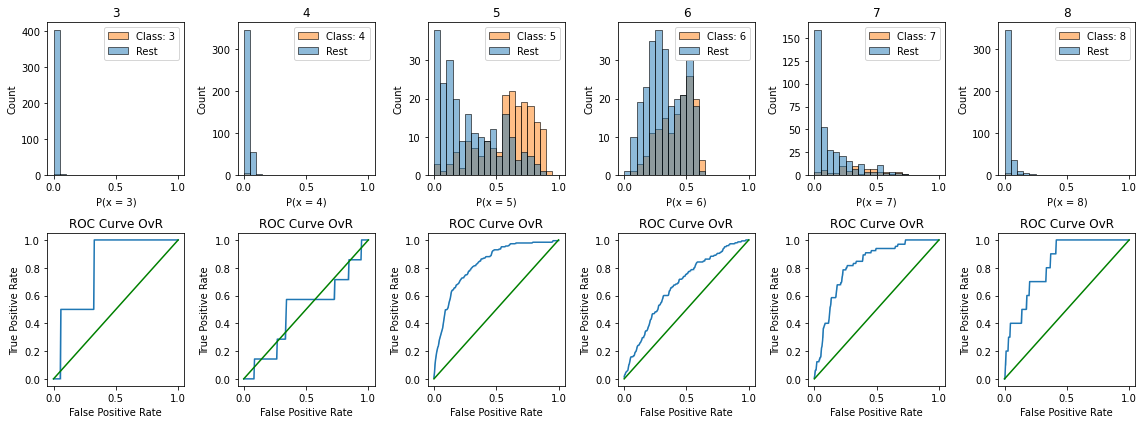

In [21]:
# Multi-class ROC curve

plt.figure(figsize = (16, 6))
bins = [i/20 for i in range(20)] + [1]
classes = model.classes_
y_proba = model.predict_proba(X_test)
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [22]:
# train model using KFold

train['kfold'] = -1
kf = KFold(n_splits=5,shuffle=True, random_state=18)
for fold,(train_indicies,valid_indicies) in enumerate(kf.split(X=train)):
    train.loc[valid_indicies,'kfold'] = fold

final_predictions = []
s = 0
print('Accuracy scores')
for fold in range(5):
    X_train =  train[train.kfold != fold].drop('kfold', axis=1)
    X_test = train[train.kfold == fold].drop('kfold', axis=1)

    y_train = X_train.pop('quality')
    y_test = X_test.pop('quality')
    
    model = LinearDiscriminantAnalysis(priors=y.value_counts(normalize=True).sort_index())
    model.fit(X_train, y_train)
    
    final_predictions.append(model.predict(test))
    
    s += accuracy_score(y_test,model.predict(X_test))
    print(fold,"- fold:", accuracy_score(y_test,model.predict(X_test)))
print("\nMean accuracy score =",s/5)

Accuracy scores
0 - fold: 0.587378640776699
1 - fold: 0.5912408759124088
2 - fold: 0.5547445255474452
3 - fold: 0.5498783454987834
4 - fold: 0.5669099756690997

Mean accuracy score = 0.5700304726808872


In [23]:
# predicted class count
pd.Series(np.array(final_predictions).mean(axis=0).round().astype('int64')).value_counts()

5    620
6    586
7    156
3      5
4      5
dtype: int64

# Submission

In [24]:
submission.quality = np.array(final_predictions).mean(axis=0).round().astype('int64')
submission.to_csv("submission.csv")
pd.read_csv("./submission.csv")

,Id,quality
0,2056,5
1,2057,5
2,2058,5
3,2059,6
4,2060,6
...,...,...
1367,3423,5
1368,3424,6
1369,3425,5
1370,3426,5
